# COVID-19 Literature Clustering

# Table of Contents
1. Loading the data
2. Pre-processing
3. Vectorization
4. PCA  & Clustering
5. Dimensionality Reduction with t-SNE
6. Topic Modeling on Each Cluster
7. Classify
8. Plot
9. How to Use the Plot?
10. Conclusion
11. Citation/Sources

<br>

In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json
!pip install Bio
import Bio
from Bio import Entrez
from Bio import Medline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [10]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

#### specification du nombre de fichiers a lire : 

In [11]:
max_articles = 1000
term = "Covid"

In [12]:
Entrez.email = 'A.N.Other@example.com'
h = Entrez.esearch(db='pubmed', retmax=max_articles, term=term)
result = Entrez.read(h)
result
ids = result['IdList']
h = Entrez.efetch(db='pubmed', id=ids, rettype='medline', retmode='json')
records = Medline.parse(h)

In [13]:
dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(records):

    if idx >max_articles:
        break
    try:
        dict_['paper_id'].append(entry["PMID"])
    except Exception as e:
        dict_['paper_id'].append("")
        
    try:
        dict_['abstract'].append(entry["AB"])
        # also create a column for the summary of abstract to be used in a plot
        if len(entry["AB"]) == 0: 
            # no abstract provided
            dict_['abstract_summary'].append("Not provided.")
        elif len(entry["AB"].split(' ')) > 100:
            # abstract provided is too long for plot, take first 100 words append with ...
            info = entry["AB"].split(' ')[:100]
            summary = get_breaks(' '.join(info), 40)
            dict_['abstract_summary'].append(summary + "...")
        else:
            # abstract is short enough
            summary = get_breaks(entry["AB"], 40)
            dict_['abstract_summary'].append(summary)
    except Exception as e:
        dict_['abstract'].append("")  
        dict_['abstract_summary'].append("Not provided.")

        
    try:
        dict_['body_text'].append(entry["AB"])
    except Exception as e:
        dict_['body_text'].append("")     
    
   
    
    
    try:
        # if more than one author
        authors = entry['AU'][0].split(',')
        if len(authors) > 2:
            # if more than 2 authors, take them all with html tag breaks in between
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        try : 
            dict_['authors'].append(entry['AU'][0])
        except Exception as e:
            dict_['authors'].append("")


    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(entry['TI'][0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        try:
            dict_['title'].append(entry['TI'][0])
        except Exception as e:
            dict_['title'].append("")
    
    # add the journal information
    dict_['journal'].append(entry['PT'][0])
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   paper_id          1000 non-null   object
 1   abstract          1000 non-null   object
 2   body_text         1000 non-null   object
 3   authors           1000 non-null   object
 4   title             1000 non-null   object
 5   journal           1000 non-null   object
 6   abstract_summary  1000 non-null   object
dtypes: object(7)
memory usage: 54.8+ KB


## Some feature engineering
Adding word count columns for both abstract and body_text can be useful parameters later:

In [14]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,33970570,Originally viewed as a few years of apprentice...,Originally viewed as a few years of apprentice...,,,Review,Originally viewed as a few years of<br>appren...,178,178,124
1,33971677,,,Limami Y,O,Journal Article,Not provided.,0,0,0
2,33971664,Betacoronaviruses (betaCoVs) caused the severe...,Betacoronaviruses (betaCoVs) caused the severe...,Saunders KO,N,Journal Article,Betacoronaviruses (betaCoVs) caused the<br>se...,145,145,111
3,33971617,OBJECTIVE: Plasma glucose has been correlated ...,OBJECTIVE: Plasma glucose has been correlated ...,Kumar B,E,Journal Article,OBJECTIVE: Plasma glucose has been correlated...,262,262,158
4,33971608,The building of an effective wastewater-based ...,The building of an effective wastewater-based ...,Cao Y,O,Journal Article,The building of an effective wastewater-based...,299,299,173


In [15]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             1000 non-null   object
 1   abstract             1000 non-null   object
 2   body_text            1000 non-null   object
 3   authors              1000 non-null   object
 4   title                1000 non-null   object
 5   journal              1000 non-null   object
 6   abstract_summary     1000 non-null   object
 7   abstract_word_count  1000 non-null   int64 
 8   body_word_count      1000 non-null   int64 
 9   body_unique_words    1000 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 78.2+ KB


In [16]:
df_covid['abstract'].describe(include='all')

count     1000
unique     794
top           
freq       207
Name: abstract, dtype: object

## Handle Possible Duplicates

When we look at the unique values above, we can see that tehre are duplicates. It may have caused because of author submiting the article to multiple journals. Let's remove the duplicats from our dataset:

(Thank you Desmond Yeoh for recommending the below approach on Kaggle)

In [17]:
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)
df_covid['abstract'].describe(include='all')

count                                                   794
unique                                                  794
top       OBJECTIVES: During the pandemic, anxiety, stre...
freq                                                      1
Name: abstract, dtype: object

In [18]:
df_covid['body_text'].describe(include='all')

count                                                   794
unique                                                  794
top       OBJECTIVES: During the pandemic, anxiety, stre...
freq                                                      1
Name: body_text, dtype: object

It looks like we didn't have duplicates. Instead, it was articles without Abstracts.

## Take a Look at the Data:

In [19]:
df_covid.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,33970570,Originally viewed as a few years of apprentice...,Originally viewed as a few years of apprentice...,,,Review,Originally viewed as a few years of<br>appren...,178,178,124
1,33971677,,,Limami Y,O,Journal Article,Not provided.,0,0,0
2,33971664,Betacoronaviruses (betaCoVs) caused the severe...,Betacoronaviruses (betaCoVs) caused the severe...,Saunders KO,N,Journal Article,Betacoronaviruses (betaCoVs) caused the<br>se...,145,145,111
3,33971617,OBJECTIVE: Plasma glucose has been correlated ...,OBJECTIVE: Plasma glucose has been correlated ...,Kumar B,E,Journal Article,OBJECTIVE: Plasma glucose has been correlated...,262,262,158
4,33971608,The building of an effective wastewater-based ...,The building of an effective wastewater-based ...,Cao Y,O,Journal Article,The building of an effective wastewater-based...,299,299,173


In the majority of this notebook we will be working with **body_text** <br>
Links to the papers will be generated using **doi** 

In [20]:
df_covid.describe()

,abstract_word_count,body_word_count,body_unique_words
count,794.000000,794.000000,794.000000
mean,213.845088,213.845088,136.196474
std,84.937600,84.937600,44.626054
min,0.000000,0.000000,0.000000
25%,162.000000,162.000000,110.250000
50%,218.500000,218.500000,139.000000
75%,255.750000,255.750000,163.000000
max,818.000000,818.000000,371.000000


# Data Pre-processing

### Réduction de la taille du dataset :

In [21]:

#df = df_covid.sample(4000, random_state=42)
df = df_covid

### Suppression des valeurs null :

Now that we have our dataset loaded, we need to clean-up the text to improve any clustering or classification efforts. First, let's drop Null vales:

In [22]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 794 entries, 0 to 999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             794 non-null    object
 1   abstract             794 non-null    object
 2   body_text            794 non-null    object
 3   authors              794 non-null    object
 4   title                794 non-null    object
 5   journal              794 non-null    object
 6   abstract_summary     794 non-null    object
 7   abstract_word_count  794 non-null    int64 
 8   body_word_count      794 non-null    int64 
 9   body_unique_words    794 non-null    int64 
dtypes: int64(3), object(7)
memory usage: 68.2+ KB


### Handling multiple languages
Next we are going to determine the language of each paper in the dataframe. Not all of the sources are English and the language needs to be identified so that we know how handle these instances

In [25]:
!pip install tqdm
import tqdm
!pip install langdetect
import langdetect
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

     |████████████████████████████████| 983kB 11.1MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-cp37-none-any.whl size=993223 sha256=b4f1b9dfe953f644bcd4c41c83810352ea0e75ff597e52ab380fb45feb7183a2
  Stored in directory: /root/.cache/pip/wheels/7e/18/13/038c34057808931c7ddc6c92d3aa015cf1a498df5a70268996
Successfully built langdetect


100%|██████████| 794/794 [00:05<00:00, 158.35it/s]


In [26]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 794

{'en': 794}


Lets take a look at the language distribution in the dataset

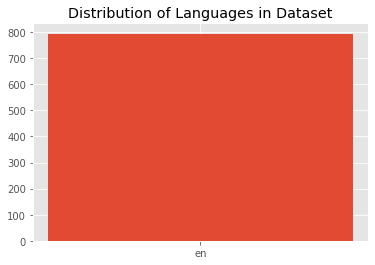

In [27]:
df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()


We will be dropping any language that is not English. Attempting to translate foreign texts gave the following problems:

1. API calls were limited

2. Translating the language may not carry over the true semantic meaning of the text


In [28]:
df = df[df['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 794 entries, 0 to 999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             794 non-null    object
 1   abstract             794 non-null    object
 2   body_text            794 non-null    object
 3   authors              794 non-null    object
 4   title                794 non-null    object
 5   journal              794 non-null    object
 6   abstract_summary     794 non-null    object
 7   abstract_word_count  794 non-null    int64 
 8   body_word_count      794 non-null    int64 
 9   body_unique_words    794 non-null    int64 
 10  language             794 non-null    object
dtypes: int64(3), object(8)
memory usage: 74.4+ KB


In [29]:
#Download the spacy bio parser

from IPython.utils import io
with io.capture_output() as captured:
  !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz

In [30]:
import spacy.cli
spacy.cli.download("en_core_web_lg")
import en_core_web_lg
nlp = en_core_web_lg.load()

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [32]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step

### Stopwords

Part of the preprocessing will be finding and removing stopwords (common words that will act as noise in the clustering step).

In [33]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
print(stopwords)
print("-----------")

print(punctuations)

['will', 'move', 'everything', 'full', 'thence', 'done', 'my', 'all', 'most', 'toward', 'they', 'there', 'again', 'been', 'anything', "'ll", 'might', 'sometimes', 'whereafter', 'formerly', 'themselves', 'many', 'nine', 'except', 'see', 'always', 'various', 'last', 'we', 'hence', 'onto', 'ten', 'am', 'have', 'also', 'for', 'noone', 'three', 'due', 'hereby', 'our', 'i', 'twenty', '’d', '‘s', 'between', 'every', 'and', 'that', "'ve", 'seemed', 'anywhere', 'only', 'thereby', 'whence', 'alone', 'whose', 'sometime', 'quite', 'being', 'five', 'perhaps', 'without', 'otherwise', 'those', 'neither', 'herself', 'very', 'third', 'mostly', 'still', 'further', 'would', 'mine', 'go', 'across', 'around', 'forty', 'whereas', 'say', 'nowhere', 'at', 'down', 'everyone', 'whither', 'to', 'made', 'much', 'behind', 'few', 'whenever', 'however', 'someone', 'front', 'me', 'using', 'up', 'now', 'call', 'out', 'somehow', 'than', 'your', 'top', 'cannot', 'his', 'amount', 'four', 'hereupon', 'which', '’m', 'ourse

Now the above stopwords are used in everyday english text. Research papers will often frequently use words that don't actually contribute to the meaning and are not considered everyday stopwords.

Thank you Daniel Wolffram for the idea.
#### Cite: [Custom Stop Words | Topic Modeling: Finding Related Articles](https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles)

In [34]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

### Next lets create a function that will process the text data for us. 
For this purpose we will be using the spacy library. This function will convert text to lower case, remove punctuation, and find and remove stopwords. For the parser, we will use en_core_sci_lg. This is a model for processing biomedical, scientific or clinical text.

In [35]:
# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)

    mytokens = [ word for word in mytokens if word not in stopwords and word.text not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

Applying the text-processing function on the **body_text**. 

In [36]:
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#c'est dans cette partie la que ça bug , ça prend un temps énorme et on a pas eu de résultat  
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#tqdm.pandas()
#df["processed_text"] = df["body_text"].progress_apply(spacy_tokenizer)

In [37]:
import spacy
nlp = en_core_web_lg.load()
def spacy_process(texte):
    tmp = []
    tmp.append(texte)
    for lt in tmp:
        mytokens = nlp(lt)
        mytokens2 = [word.lemma_.lower().strip() for word in mytokens if word.pos_ != "PUNCT" and word.text not in stopwords]
        mytokens2 = " ".join([i for i in mytokens2])
    return mytokens2
df["processed_text"] = df["body_text"].apply(spacy_process)

### Exemple

In [38]:
test1 = spacy_process("vaccinations")
test2 = spacy_process("vaccination")
test3 = spacy_process("vaccinating")
test4 = spacy_process("vaccinated")
print(test1)
print(test2)
print(test3)
print(test4)

vaccination
vaccination
vaccinate
vaccinate


In [39]:
df.head()


,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language,processed_text
0,33970570,Originally viewed as a few years of apprentice...,Originally viewed as a few years of apprentice...,,,Review,Originally viewed as a few years of<br>appren...,178,178,124,en,originally view year apprenticeship opportunit...
1,33971677,,,Limami Y,O,Journal Article,Not provided.,0,0,0,en,
2,33971664,Betacoronaviruses (betaCoVs) caused the severe...,Betacoronaviruses (betaCoVs) caused the severe...,Saunders KO,N,Journal Article,Betacoronaviruses (betaCoVs) caused the<br>se...,145,145,111,en,betacoronaviruses betacovs cause severe acute ...
3,33971617,OBJECTIVE: Plasma glucose has been correlated ...,OBJECTIVE: Plasma glucose has been correlated ...,Kumar B,E,Journal Article,OBJECTIVE: Plasma glucose has been correlated...,262,262,158,en,objective plasma glucose correlate hospital mo...
4,33971608,The building of an effective wastewater-based ...,The building of an effective wastewater-based ...,Cao Y,O,Journal Article,The building of an effective wastewater-based...,299,299,173,en,the building effective wastewater base epidemi...


In [40]:
nlp = en_core_web_lg.load()

tmp = "The COVID-19 pandemic poses new challenges"
for lt in tmp:
    mytokens = nlp(lt)
    mytokens2 = [word.lemma_.lower().strip() for word in mytokens]
    mytokens2 = " ".join([i for i in mytokens2])
    print(mytokens2)


t
h
e

c
o
v
i
d
-
1
9

p
a
n
d
e
m
i
c

p
o
s
e
s

n
e
w

c
h
a
l
l
e
n
g
e
s


In [43]:
processed_text = df["processed_text"]
body_text = df["body_text"]

for i in range(1,10):
    print(body_text[i])
    print("")
    print(processed_text[i])
    print("")
    print("----------------------------------------------------------")







----------------------------------------------------------
Betacoronaviruses (betaCoVs) caused the severe acute respiratory syndrome (SARS) and Middle East Respiratory Syndrome (MERS) outbreaks, and the SARS-CoV-2 pandemic(1-4). Vaccines that elicit protective immunity against SARS-CoV-2 and betaCoVs circulating in animals have the potential to prevent future betaCoV pandemics. Here, we show that macaque immunization with a multimeric SARS-CoV-2 receptor binding domain (RBD) nanoparticle adjuvanted with 3M-052/Alum elicited cross-neutralizing antibody (cross-nAb) responses against batCoVs, SARS-CoV-1, SARS-CoV-2, and SARS-CoV-2 variants B.1.1.7, P.1, and B.1.351. Nanoparticle vaccination resulted in a SARS-CoV-2 reciprocal geometric mean neutralization ID50 titer of 47,216, and protection against SARS-CoV-2 in macaque upper and lower respiratory tracts. Importantly, nucleoside-modified mRNA encoding a stabilized transmembrane spike or monomeric RBD also induced SARS-CoV-1 and batCo

### Removal of Frequent words
So this step is to remove the frequent words in the given corpus. If we use something like tfidf, this is automatically taken care of.

In [44]:
from collections import Counter
cnt = Counter()
for text in df["processed_text"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(40)

[('covid-19', 2294),
 ('patient', 1418),
 ('the', 1353),
 ('%', 1201),
 ('-', 1028),
 ('sars', 845),
 ('study', 838),
 ('cov-2', 778),
 ('pandemic', 764),
 ('health', 651),
 ('disease', 626),
 ('result', 590),
 ('infection', 504),
 ('we', 483),
 ('high', 453),
 ('in', 414),
 ('include', 405),
 ('risk', 398),
 ('2020', 395),
 ('coronavirus', 395),
 ('this', 375),
 ('=', 364),
 ('increase', 360),
 ('method', 360),
 ('datum', 354),
 ('case', 346),
 ('vaccine', 341),
 ('level', 339),
 ('severe', 338),
 ('report', 329),
 ('/', 324),
 ('group', 322),
 ('associate', 320),
 ('analysis', 315),
 ('care', 309),
 ('model', 307),
 ('clinical', 304),
 ('a', 285),
 ('conclusion', 280),
 ('respiratory', 272)]

In [45]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(30)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df["text_wo_stopfreq"] = df["processed_text"].apply(lambda text: remove_freqwords(text))


In [46]:
df["body_text"]

0      Originally viewed as a few years of apprentice...
1                                                       
2      Betacoronaviruses (betaCoVs) caused the severe...
3      OBJECTIVE: Plasma glucose has been correlated ...
4      The building of an effective wastewater-based ...
                             ...                        
993    Thrombosis is the most feared complication of ...
996    Epidemiological evidence establishes obesity a...
997    Healthcare workers (HCWs) are at an increased ...
998    ACE2 and TMPRSS2 are key players on SARS-CoV-2...
999    This paper examines whether compliance with CO...
Name: body_text, Length: 794, dtype: object

In [47]:
df["text_wo_stopfreq"]

0      originally view year apprenticeship opportunit...
1                                                       
2      betacoronaviruses betacovs cause acute respira...
3      objective plasma glucose correlate hospital mo...
4      building effective wastewater base epidemiolog...
                             ...                        
993    thrombosis fear complication cardiovascular ma...
996    epidemiological evidence establish obesity ind...
997    healthcare worker hcw increased acute respirat...
998    ace2 tmprss2 key player entry host cell howeve...
999    paper examine compliance mitigation measure mo...
Name: text_wo_stopfreq, Length: 794, dtype: object

In [48]:
df["processed_text"]

0      originally view year apprenticeship opportunit...
1                                                       
2      betacoronaviruses betacovs cause severe acute ...
3      objective plasma glucose correlate hospital mo...
4      the building effective wastewater base epidemi...
                             ...                        
993    thrombosis fear complication cardiovascular di...
996    epidemiological evidence establish obesity ind...
997    healthcare worker hcw increased risk severe ac...
998    ace2 tmprss2 key player sars cov-2 entry host ...
999    this paper examine compliance covid-19 mitigat...
Name: processed_text, Length: 794, dtype: object

### Removal of Rare words
This is very similar to previous preprocessing step but we will remove the rare words from the corpus.

In [49]:
#cnt.most_common()[:-500-1:-1]

In [50]:
# n_rare_words = 10
# RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
# def remove_rarewords(text):
#     """custom function to remove the rare words"""
#     return " ".join([word for word in str(text).split() if word not in RAREWORDS])

# df["text_wo_stopfreqrare"] = df["text_wo_stopfreq"].apply(lambda text: remove_rarewords(text))
# df.head()

### Lemmatization

Lemmatization is similar to stemming in reducing inflected words to their word stem but differs in the way that it makes sure the root word (also called as lemma) belongs to the language.

In [55]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Now let us redo the lemmatization process for our dataset.

In [56]:
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [57]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word) for word, pos in pos_tagged_text])

df["text_lemmatized"] = df["text_wo_stopfreq"].apply(lambda text: lemmatize_words(text))


In [58]:
df.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language,processed_text,text_wo_stopfreq,text_lemmatized
0,33970570,Originally viewed as a few years of apprentice...,Originally viewed as a few years of apprentice...,,,Review,Originally viewed as a few years of<br>appren...,178,178,124,en,originally view year apprenticeship opportunit...,originally view year apprenticeship opportunit...,originally view year apprenticeship opportunit...
1,33971677,,,Limami Y,O,Journal Article,Not provided.,0,0,0,en,,,
2,33971664,Betacoronaviruses (betaCoVs) caused the severe...,Betacoronaviruses (betaCoVs) caused the severe...,Saunders KO,N,Journal Article,Betacoronaviruses (betaCoVs) caused the<br>se...,145,145,111,en,betacoronaviruses betacovs cause severe acute ...,betacoronaviruses betacovs cause acute respira...,betacoronaviruses betacovs cause acute respira...
3,33971617,OBJECTIVE: Plasma glucose has been correlated ...,OBJECTIVE: Plasma glucose has been correlated ...,Kumar B,E,Journal Article,OBJECTIVE: Plasma glucose has been correlated...,262,262,158,en,objective plasma glucose correlate hospital mo...,objective plasma glucose correlate hospital mo...,objective plasma glucose correlate hospital mo...
4,33971608,The building of an effective wastewater-based ...,The building of an effective wastewater-based ...,Cao Y,O,Journal Article,The building of an effective wastewater-based...,299,299,173,en,the building effective wastewater base epidemi...,building effective wastewater base epidemiolog...,building effective wastewater base epidemiolog...


In [61]:
processed_text = df["processed_text"]
body_text = df["body_text"]
text_lemmatized = df["text_lemmatized"]

for i in range(1,10):
    print(body_text[i])
    print("")
    print(processed_text[i])
    print("")
    print(text_lemmatized[i])
    print("----------------------------------------------------------")








----------------------------------------------------------
Betacoronaviruses (betaCoVs) caused the severe acute respiratory syndrome (SARS) and Middle East Respiratory Syndrome (MERS) outbreaks, and the SARS-CoV-2 pandemic(1-4). Vaccines that elicit protective immunity against SARS-CoV-2 and betaCoVs circulating in animals have the potential to prevent future betaCoV pandemics. Here, we show that macaque immunization with a multimeric SARS-CoV-2 receptor binding domain (RBD) nanoparticle adjuvanted with 3M-052/Alum elicited cross-neutralizing antibody (cross-nAb) responses against batCoVs, SARS-CoV-1, SARS-CoV-2, and SARS-CoV-2 variants B.1.1.7, P.1, and B.1.351. Nanoparticle vaccination resulted in a SARS-CoV-2 reciprocal geometric mean neutralization ID50 titer of 47,216, and protection against SARS-CoV-2 in macaque upper and lower respiratory tracts. Importantly, nucleoside-modified mRNA encoding a stabilized transmembrane spike or monomeric RBD also induced SARS-CoV-1 and batC

### Removal of URLs

In [62]:
import re
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [63]:
df["text_lemmatized_no_url"] = df["text_lemmatized"].apply(lambda text: remove_urls(text))
df.head()
    

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language,processed_text,text_wo_stopfreq,text_lemmatized,text_lemmatized_no_url
0,33970570,Originally viewed as a few years of apprentice...,Originally viewed as a few years of apprentice...,,,Review,Originally viewed as a few years of<br>appren...,178,178,124,en,originally view year apprenticeship opportunit...,originally view year apprenticeship opportunit...,originally view year apprenticeship opportunit...,originally view year apprenticeship opportunit...
1,33971677,,,Limami Y,O,Journal Article,Not provided.,0,0,0,en,,,,
2,33971664,Betacoronaviruses (betaCoVs) caused the severe...,Betacoronaviruses (betaCoVs) caused the severe...,Saunders KO,N,Journal Article,Betacoronaviruses (betaCoVs) caused the<br>se...,145,145,111,en,betacoronaviruses betacovs cause severe acute ...,betacoronaviruses betacovs cause acute respira...,betacoronaviruses betacovs cause acute respira...,betacoronaviruses betacovs cause acute respira...
3,33971617,OBJECTIVE: Plasma glucose has been correlated ...,OBJECTIVE: Plasma glucose has been correlated ...,Kumar B,E,Journal Article,OBJECTIVE: Plasma glucose has been correlated...,262,262,158,en,objective plasma glucose correlate hospital mo...,objective plasma glucose correlate hospital mo...,objective plasma glucose correlate hospital mo...,objective plasma glucose correlate hospital mo...
4,33971608,The building of an effective wastewater-based ...,The building of an effective wastewater-based ...,Cao Y,O,Journal Article,The building of an effective wastewater-based...,299,299,173,en,the building effective wastewater base epidemi...,building effective wastewater base epidemiolog...,building effective wastewater base epidemiolog...,building effective wastewater base epidemiolog...


### Removal of HTML Tags

In [64]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

In [65]:
df["text_lemmatized_url_html"] = df["text_lemmatized_no_url"].apply(lambda text: remove_html(text))
df.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language,processed_text,text_wo_stopfreq,text_lemmatized,text_lemmatized_no_url,text_lemmatized_url_html
0,33970570,Originally viewed as a few years of apprentice...,Originally viewed as a few years of apprentice...,,,Review,Originally viewed as a few years of<br>appren...,178,178,124,en,originally view year apprenticeship opportunit...,originally view year apprenticeship opportunit...,originally view year apprenticeship opportunit...,originally view year apprenticeship opportunit...,originally view year apprenticeship opportunit...
1,33971677,,,Limami Y,O,Journal Article,Not provided.,0,0,0,en,,,,,
2,33971664,Betacoronaviruses (betaCoVs) caused the severe...,Betacoronaviruses (betaCoVs) caused the severe...,Saunders KO,N,Journal Article,Betacoronaviruses (betaCoVs) caused the<br>se...,145,145,111,en,betacoronaviruses betacovs cause severe acute ...,betacoronaviruses betacovs cause acute respira...,betacoronaviruses betacovs cause acute respira...,betacoronaviruses betacovs cause acute respira...,betacoronaviruses betacovs cause acute respira...
3,33971617,OBJECTIVE: Plasma glucose has been correlated ...,OBJECTIVE: Plasma glucose has been correlated ...,Kumar B,E,Journal Article,OBJECTIVE: Plasma glucose has been correlated...,262,262,158,en,objective plasma glucose correlate hospital mo...,objective plasma glucose correlate hospital mo...,objective plasma glucose correlate hospital mo...,objective plasma glucose correlate hospital mo...,objective plasma glucose correlate hospital mo...
4,33971608,The building of an effective wastewater-based ...,The building of an effective wastewater-based ...,Cao Y,O,Journal Article,The building of an effective wastewater-based...,299,299,173,en,the building effective wastewater base epidemi...,building effective wastewater base epidemiolog...,building effective wastewater base epidemiolog...,building effective wastewater base epidemiolog...,building effective wastewater base epidemiolog...


### Let's take a look at word count in the papers

In [66]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    794.000000
mean     213.845088
std       84.937600
min        0.000000
25%      162.000000
50%      218.500000
75%      255.750000
max      818.000000
Name: body_word_count, dtype: float64

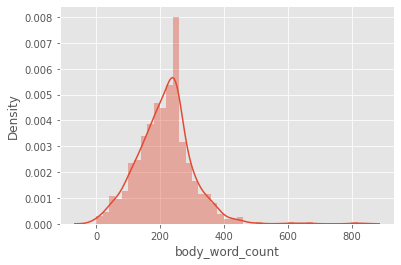

In [67]:
sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    794.000000
mean     136.196474
std       44.626054
min        0.000000
25%      110.250000
50%      139.000000
75%      163.000000
max      371.000000
Name: body_unique_words, dtype: float64

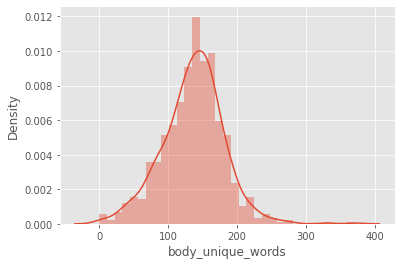

In [68]:
sns.distplot(df['body_unique_words'])
df['body_unique_words'].describe()

These two plots give us a good idea of the content we are dealing with. Most papers are about 5000 words in length. The long tails in both plots are caused by outliers. In fact, ~98% of the papers are under 20,000 words in length while a select few are over 200,000! <br><br>

# Vectorization

Now that we have pre-processed the data, it is time to convert it into a format that can be handled by our algorithms. For this purpose we will be using tf-idf. This will convert our string formatted data into a measure of how important each word is to the instance out of the literature as a whole.

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    global vectorizer 
    X = vectorizer.fit_transform(text)
    return X

Vectorize our data. We will be clustering based off the content of the body text. The maximum number of features will be limited. Only the top 2 ** 12 features will be used, eseentially acting as a noise filter. Additionally, more features cause painfully long runtimes.

In [70]:
text = df['text_lemmatized_url_html'].values
vectorizer = TfidfVectorizer(max_features= 2 ** 12)
X = vectorize(text, 2 ** 12)
X.shape
print(X)

  (0, 2482)	0.05197202646276644
  (0, 1031)	0.059043882807908885
  (0, 3594)	0.06429558567428478
  (0, 533)	0.07847418264578339
  (0, 3298)	0.07063060854020187
  (0, 2326)	0.04954946183833965
  (0, 2372)	0.03657387815236671
  (0, 1434)	0.04535143856893978
  (0, 883)	0.042934109655671945
  (0, 2184)	0.0604236187315828
  (0, 1932)	0.05120030870232735
  (0, 869)	0.05023330471149782
  (0, 962)	0.09005094084236612
  (0, 4067)	0.15694836529156678
  (0, 979)	0.03767373620528334
  (0, 688)	0.08250633417325817
  (0, 205)	0.06195415585592726
  (0, 2545)	0.08818933256472065
  (0, 3326)	0.06142518747139596
  (0, 1406)	0.07534660294083481
  (0, 3019)	0.08506175285977208
  (0, 3743)	0.08506175285977208
  (0, 64)	0.05523246022980213
  (0, 46)	0.054580435755347524
  (0, 1339)	0.05948887251934085
  :	:
  (793, 2101)	0.07773693336062067
  (793, 1733)	0.09042856925484859
  (793, 2602)	0.07931724572499961
  (793, 1123)	0.18538261329529226
  (793, 579)	0.09322974779158476
  (793, 1115)	0.11391959164098134


# PCA  & Clustering

Let's see how much we can reduce the dimensions while still keeping 95% variance. We will apply Principle Component Analysis (PCA) to our vectorized data. The reason for this is that by keeping a large number of dimensions with PCA, you don’t destroy much of the information, but hopefully will remove some noise/outliers from the data, and make the clustering problem easier for k-means. Note that X_reduced will only be used for k-means, t-SNE will still use the original feature vector X that was generated through tf-idf on the NLP processed text.

(Thank you Dr. Edward Raff for the suggestion)

In [71]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(794, 668)

To separate the literature, k-means will be run on the vectorized text. Given the number of clusters, k, k-means will categorize each vector by taking the mean distance to a randomly initialized centroid. The centroids are updated iteratively.

In [72]:
from sklearn.cluster import KMeans

### How many clusters? 

To find the best k value for k-means we'll look at the distortion at different k values. Distortion computes the sum of squared distances from each point to its assigned center. When distortion is plotted against k there will be a k value after which decreases in distortion are minimal. This is the desired number of clusters.

In [73]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 10)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

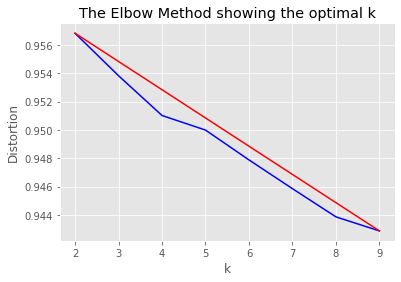

In [74]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In this plot we can see that the better k values are between 18-25. After that, the decrease in distortion is not as significant. For simplicity, we will use k=20

### Run k-means

Now that we have an appropriate k value, we can run k-means on the PCA-processed feature vector (X_reduced). 

In [75]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred
df['y']

0      1
1      1
2      0
3      2
4      2
      ..
993    3
996    3
997    2
998    2
999    1
Name: y, Length: 794, dtype: int32

# Dimensionality Reduction with t-SNE

In [76]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 794 samples in 0.201s...
[t-SNE] Computed neighbors for 794 samples in 4.167s...
[t-SNE] Computed conditional probabilities for sample 794 / 794
[t-SNE] Mean sigma: 0.430349
[t-SNE] KL divergence after 250 iterations with early exaggeration: 97.860291
[t-SNE] KL divergence after 1000 iterations: 2.754103


So that step took a while! Let's take a look at what our data looks like when compressed to 2 dimensions. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


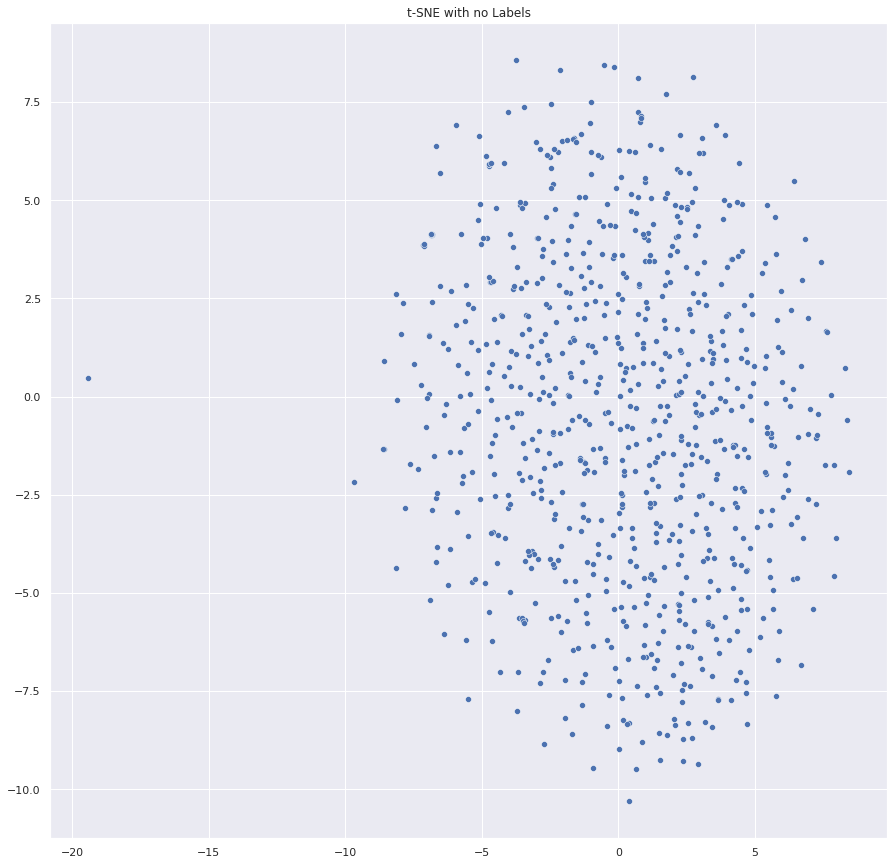

In [77]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

This looks pretty bland. There are some clusters we can immediately detect, but the many instances closer to the center are harder to separate. t-SNE did a good job at reducing the dimensionality, but now we need some labels. Let's use the clusters found by k-means as labels. This will help visually separate different concentrations of topics.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


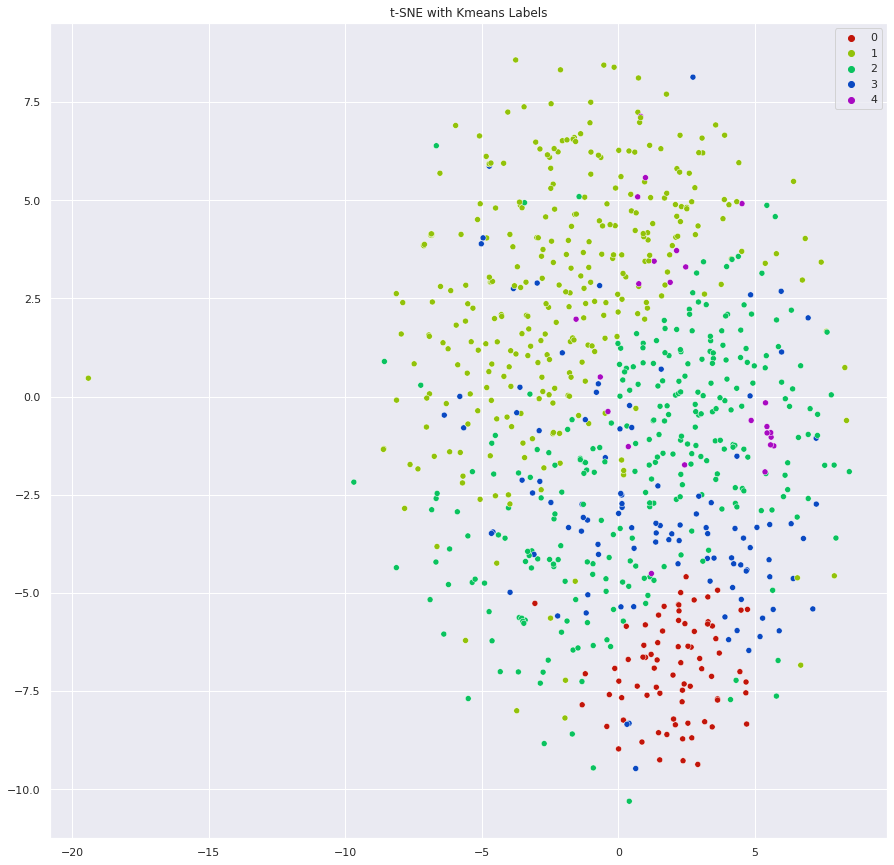

In [78]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(5, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

The labeled plot gives better insight into how the papers are grouped. It is interesting that both k-means and t-SNE are able to agree on certain clusters even though they were ran independetly. The location of each paper on the plot was determined by t-SNE while the label (color) was determined by k-means. If we look at a particular part of the plot where t-SNE has grouped many articles forming a cluster, it is likely that k-means is uniform in the labeling of this cluster (most of the cluster is the same color). This behavior shows that structure within the literature can be observed and measured to some extent. 

Now there are other cases where the colored labels (k-means) are spread out on the plot (t-SNE). This is a result of t-SNE and k-means finding different connections in the higher dimensional data. The topics of these papers often intersect so it hard to cleanly separate them. This effect can be observed in the formation of subclusters on the plot. These subclusters are a conglomeration of different k-means labels but may share some connection determined by t-SNE.

This organization of the data does not act as a simple search engine. The clustering + dimensionality reduction is performed on the mathematical similarities of the publications. As an unsupervised approach, the algorithms may even find connections that were unnaparent to humans. This may highlight hidden shared information and advance further research.


# NMF

In [81]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz
import en_ner_bc5cdr_md
nlp = spacy.load("en_ner_bc5cdr_md")

     |████████████████████████████████| 125.1MB 106kB/s 
  Created wheel for en-ner-bc5cdr-md: filename=en_ner_bc5cdr_md-0.4.0-cp37-none-any.whl size=125666883 sha256=b599de40df273802933c5d5d76229ce7d4cce9981e2f627468e6ea6ab495aa9a
  Stored in directory: /root/.cache/pip/wheels/fd/a0/5f/8e76c330a6c33638db0f177d6b5969a4b7623f7b1f609bb5d2
Successfully built en-ner-bc5cdr-md


In [82]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
nmf = NMF(n_components=20, random_state=1,
          alpha=.1, l1_ratio=.5).fit(X)

In [84]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(5, 4, figsize=(30, 60), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [ ]:
#vectorizer = TfidfVectorizer(max_features= 2 ** 12)


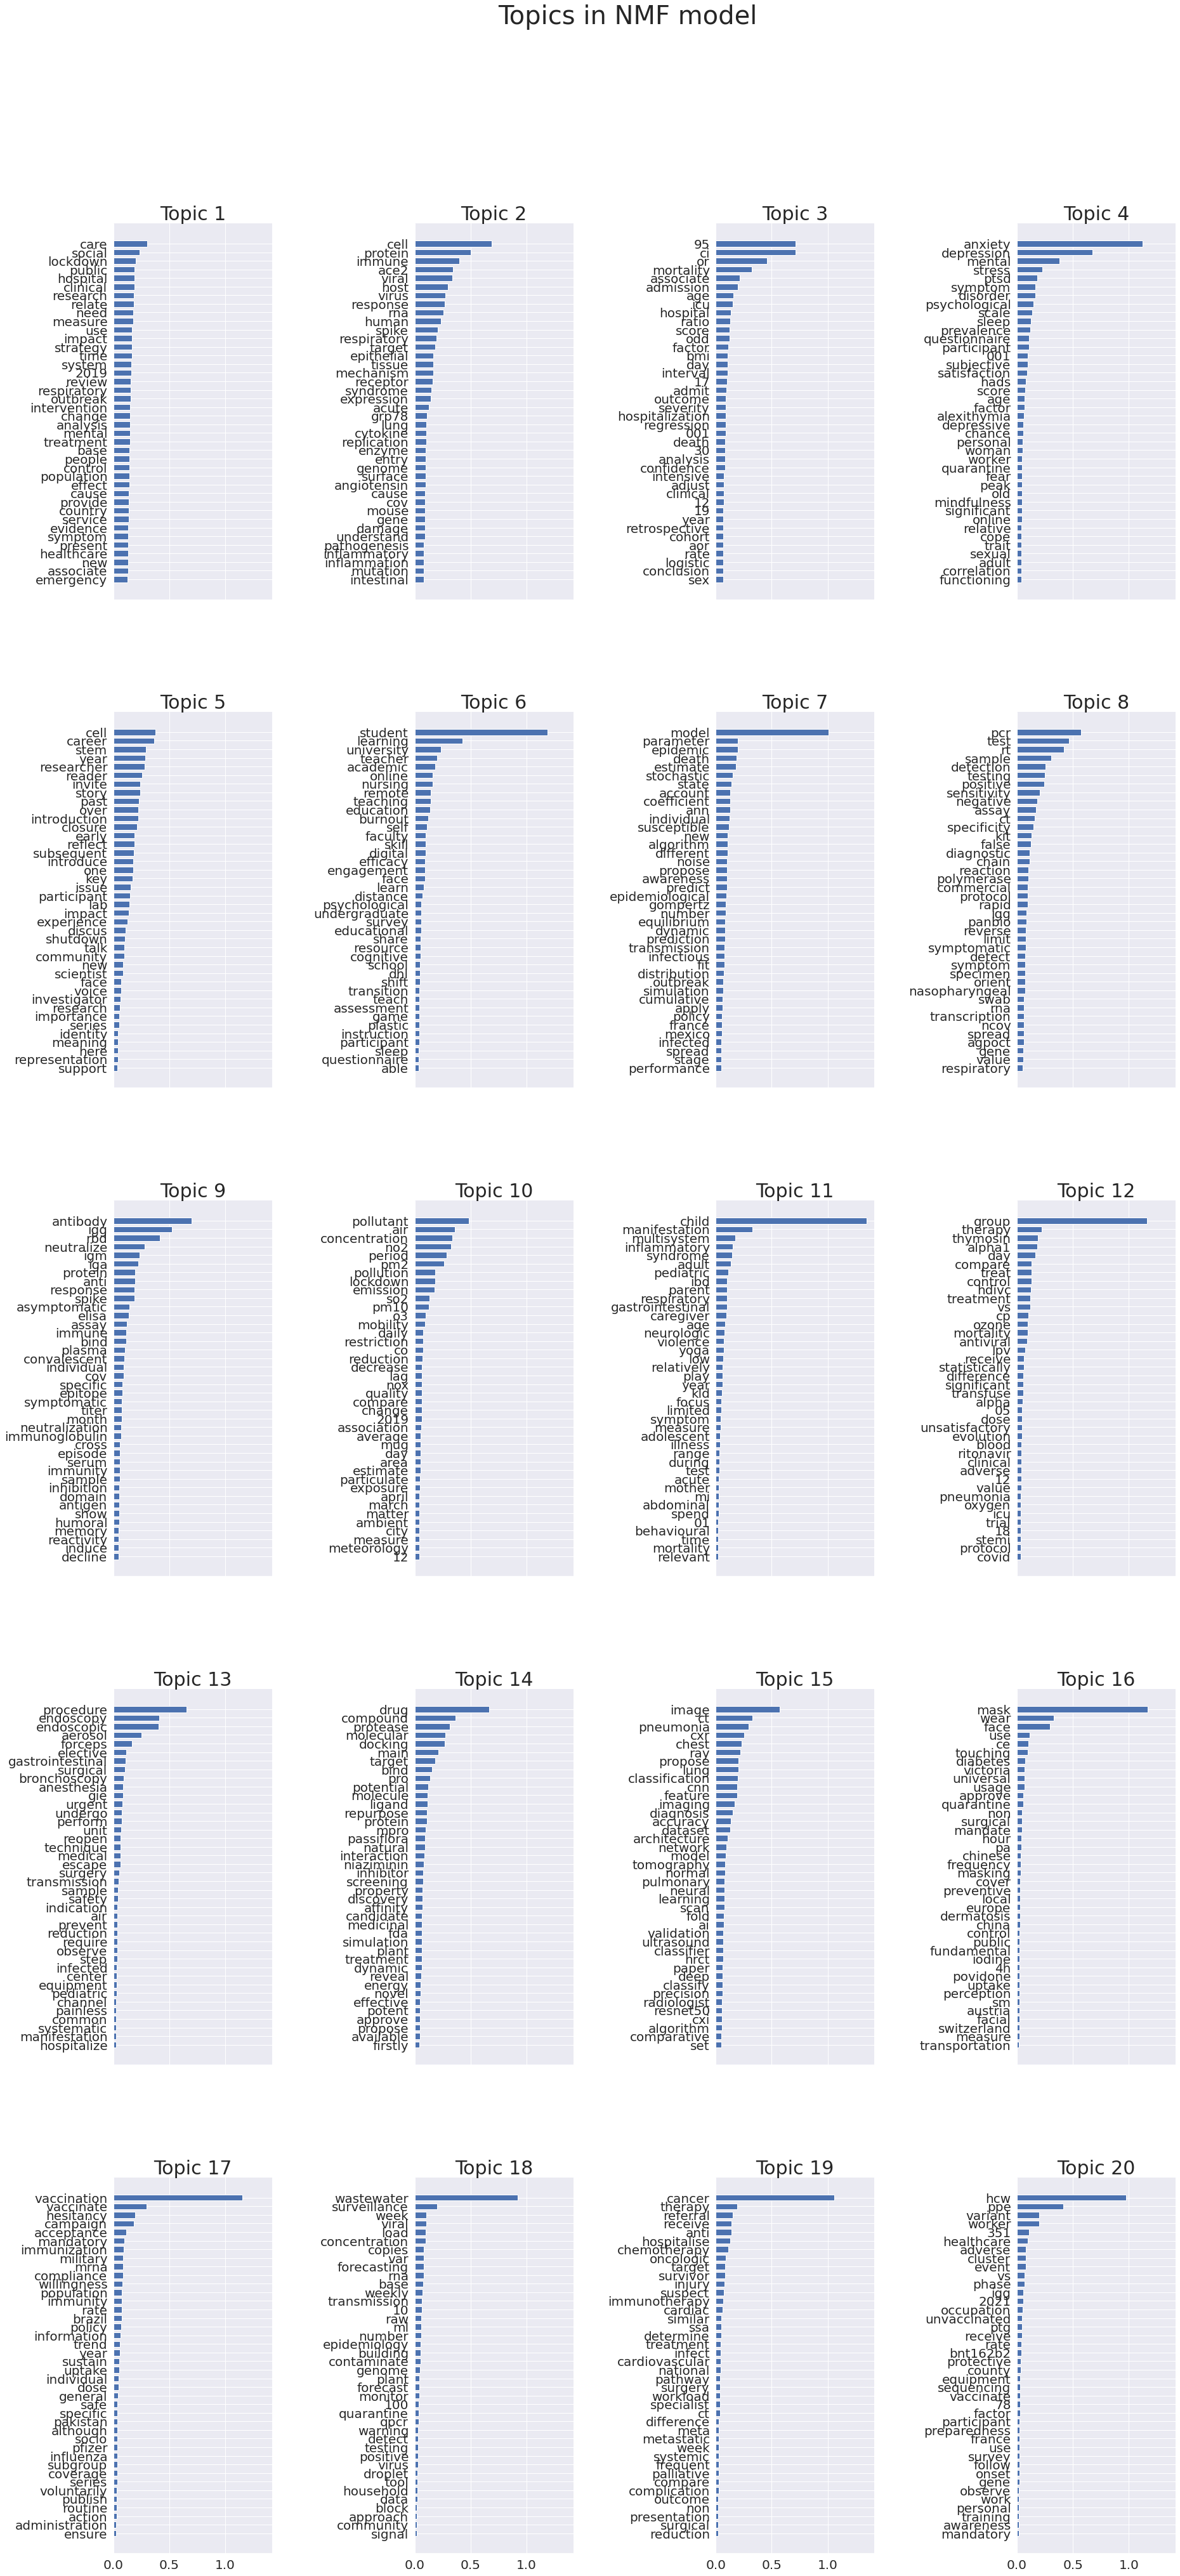

In [86]:
tfidf_feature_names = vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, 40,
               'Topics in NMF model')

In [87]:
all_keywords = []
for topic_idx, topic in enumerate(nmf.components_):
    #top words = 100
    top_features_ind = topic.argsort()[:-40 - 1:-1]
    top_features = [tfidf_feature_names[i] for i in top_features_ind]
    all_keywords.append(top_features)

In [88]:
for num_clus in range(0,20):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ','.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    TERM_LIST = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,TERM_LIST )
    print("")

*************Cluster  0 *********************
care,social,lockdown,public,hospital,clinical,research,relate,need,measure,use,impact,strategy,time,system,2019,review,respiratory,outbreak,intervention,change,analysis,mental,treatment,base,people,control,population,effect,cause,provide,country,service,evidence,symptom,present,healthcare,new,associate,emergency
-------------------------------------------
TERM_LIST :  []

*************Cluster  1 *********************
cell,protein,immune,ace2,viral,host,virus,response,rna,human,spike,respiratory,target,epithelial,tissue,mechanism,receptor,syndrome,expression,acute,grp78,lung,cytokine,replication,enzyme,entry,genome,surface,angiotensin,cause,cov,mouse,gene,damage,understand,pathogenesis,inflammatory,inflammation,mutation,intestinal
-------------------------------------------
TERM_LIST :  ['inflammation']

*************Cluster  2 *********************
95,ci,or,mortality,associate,admission,age,icu,hospital,ratio,score,odd,factor,bmi,day,interv

# Word's Similarity

In [95]:
! python3 -m spacy download en_core_web_md
import spacy
nlp = spacy.load('en_core_web_md')
cov_word =nlp("coronavirus")
for num_clus in range(0,20):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ' '.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    words = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,words)
    print("")
    for token in doc:
        #print(token.text, token.has_vector, token.vector_norm, token.is_oov) 
        if cov_word.similarity(token) > 0.5 :
            print("Similarity Between {",cov_word,"} and {",token,"} is :   ",cov_word.similarity(token))
    print("__________________________________________________________________")


2021-05-11 11:46:24.860503: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
*************Cluster  0 *********************
care social lockdown public hospital clinical research relate need measure use impact strategy time system 2019 review respiratory outbreak intervention change analysis mental treatment base people control population effect cause provide country service evidence symptom present healthcare new associate emergency
-------------------------------------------
TERM_LIST :  []

Similarity Between { coronavirus } and { outbreak } is :    0.5746238784930114
__________________________________________________________________
*************Cluster  1 *********************
cell protein immune ace2 viral host virus response rna human spike respiratory target epithelial tissue mechanism receptor syndrome expressi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  app.launch_new_instance()


0.7662567525882018
__________________________________________________________________
*************Cluster  7 *********************
pcr test rt sample detection testing positive sensitivity negative assay ct specificity kit false diagnostic chain reaction polymerase commercial protocol rapid igg panbio reverse limit symptomatic detect symptom specimen orient nasopharyngeal swab rna transcription ncov spread agpoct gene value respiratory
-------------------------------------------
TERM_LIST :  []

__________________________________________________________________
*************Cluster  8 *********************
antibody igg rbd neutralize igm iga protein anti response spike asymptomatic elisa assay immune bind plasma convalescent individual cov specific epitope symptomatic titer month neutralization immunoglobulin cross episode serum immunity sample inhibition domain antigen show humoral memory reactivity induce decline
-------------------------------------------
TERM_LIST :  []

Similarit

In [96]:
import spacy
nlp = spacy.load('en_core_web_md')
cov_word =nlp("coronavirus")
top_similar = []
for num_clus in range(0,20):
    str1 = ' '.join(all_keywords[num_clus])
    doc = nlp(str1)
    words = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    for token in doc:
        if cov_word.similarity(token) > 0.5 :
            top_similar.append((token.text , cov_word.similarity(token)))
LL = top_similar
top_similar_sorted = []
for a in top_similar :
    if a not in top_similar_sorted:
        top_similar_sorted.append(a)
top_similar_sorted = sorted(top_similar_sorted, key=lambda tup: tup[1],reverse=True)
top_similar_sorted

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  # Remove the CWD from sys.path while we load stuff.


[('virus', 0.999999842334632),
 ('infected', 0.7662567525882018),
 ('pneumonia', 0.7140131061301552),
 ('viral', 0.678927910430069),
 ('infect', 0.6573915586705649),
 ('influenza', 0.6127955278394492),
 ('outbreak', 0.5746238784930114),
 ('quarantine', 0.5746238784930114),
 ('pathogenesis', 0.5332051459892988),
 ('infectious', 0.5332051459892988),
 ('immune', 0.524877441820188),
 ('humoral', 0.524877441820188),
 ('immunotherapy', 0.5212766552274143),
 ('vaccination', 0.5161907679905197),
 ('immunization', 0.5161907679905197),
 ('epidemic', 0.501044679163086)]

In [97]:
li = top_similar_sorted[0:10]

In [98]:
nlp = spacy.load('en_core_web_md')
lii = []
for tup in li:
    cov_word =nlp(tup[0])
    top_similar = []
    for num_clus in range(0,20):
        str1 = ' '.join(all_keywords[num_clus])
        doc = nlp(str1)
        words = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
        for token in doc:
            if cov_word.similarity(token) > 0.5 :
                top_similar.append((token.text , cov_word.similarity(token)))
    top_similar_sorted = []
    for a in top_similar :
        if a not in top_similar_sorted:
            top_similar_sorted.append(a)
    top_similar_sorted = sorted(top_similar_sorted, key=lambda tup: tup[1],reverse=True)
    top_similar_sorted = top_similar_sorted[0:10]
    lii.append((tup[0],top_similar_sorted))
# LL = top_similar
# top_similar_sorted = []
# for a in top_similar :
#     if a not in top_similar_sorted:
#         top_similar_sorted.append(a)
# top_similar_sorted = sorted(top_similar_sorted, key=lambda tup: tup[1],reverse=True)
# top_similar_sorted
top_ten_of_ten = lii
top_ten_of_ten

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  # This is added back by InteractiveShellApp.init_path()


[('virus',
  [('virus', 1.0),
   ('infected', 0.7662567525882018),
   ('pneumonia', 0.7140131061301552),
   ('viral', 0.678927910430069),
   ('infect', 0.6573915586705649),
   ('influenza', 0.6127955278394492),
   ('outbreak', 0.5746238784930114),
   ('quarantine', 0.5746238784930114),
   ('pathogenesis', 0.5332051459892988),
   ('infectious', 0.5332051459892988)]),
 ('infected',
  [('infected', 1.0),
   ('pneumonia', 0.7772617769646231),
   ('virus', 0.7662567171960497),
   ('infect', 0.7569955030783959),
   ('susceptible', 0.5712258852984328),
   ('titer', 0.5637537602579952),
   ('vaccinate', 0.5637537602579952),
   ('unvaccinated', 0.5637537602579952),
   ('viral', 0.5504599078840863),
   ('outbreak', 0.5494164470616013)]),
 ('pneumonia',
  [('pneumonia', 1.0),
   ('infected', 0.777261824309824),
   ('virus', 0.7140131166435965),
   ('pathogenesis', 0.6859604871397378),
   ('infectious', 0.6859604871397378),
   ('onset', 0.6794810747887429),
   ('antiviral', 0.6427989834880435),
  

In [99]:

ten_diseases = []
for i,mots in top_similar_sorted :
    if mots not in ten_diseases:
        ten_diseases.append(i)
ten_diseases

['pathogenesis',
 'infectious',
 'neurologic',
 'hospitalization',
 'illness',
 'pneumonia',
 'diabetes',
 'cardiovascular',
 'onset',
 'epidemic']

In [100]:
hundred_diseases = []
for i,mots in top_ten_of_ten :
    for mot,val in mots:
        if mot not in hundred_diseases:
            hundred_diseases.append(mot)
hundred_diseases


['virus',
 'infected',
 'pneumonia',
 'viral',
 'infect',
 'influenza',
 'outbreak',
 'quarantine',
 'pathogenesis',
 'infectious',
 'susceptible',
 'titer',
 'vaccinate',
 'unvaccinated',
 'onset',
 'antiviral',
 'complication',
 'acute',
 'immune',
 'humoral',
 'hospitalize',
 'immunotherapy',
 'vaccination',
 'immunization',
 'epidemic',
 'hospitalization',
 'illness',
 'neurologic',
 'diabetes',
 'cardiovascular']

In [101]:
print(lemmatizer.lemmatize("diabete"))
print(lemmatizer.lemmatize("diabetes"))
print(lemmatizer.lemmatize("diabetic"))

print(lemmatizer.lemmatize("feet"))

print(lemmatizer.lemmatize("vaccinations"))
print(lemmatizer.lemmatize("vaccination"))
print(lemmatizer.lemmatize("vaccinated"))

print(lemmatizer.lemmatize("speaking"))
print(lemmatizer.lemmatize("speaks"))
print(lemmatizer.lemmatize("spoken"))



diabete
diabetes
diabetic
foot
vaccination
vaccination
vaccinated
speaking
speaks
spoken


# LDA

In [102]:
nlp = spacy.load("en_ner_bc5cdr_md")

In [103]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

tf = CountVectorizer(max_df=0.9, min_df=5, stop_words='english')
tff = tf.fit_transform(text)
lda = LatentDirichletAllocation(n_components=20, max_iter=10, learning_method='online', random_state=42)
lda.fit(tff)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

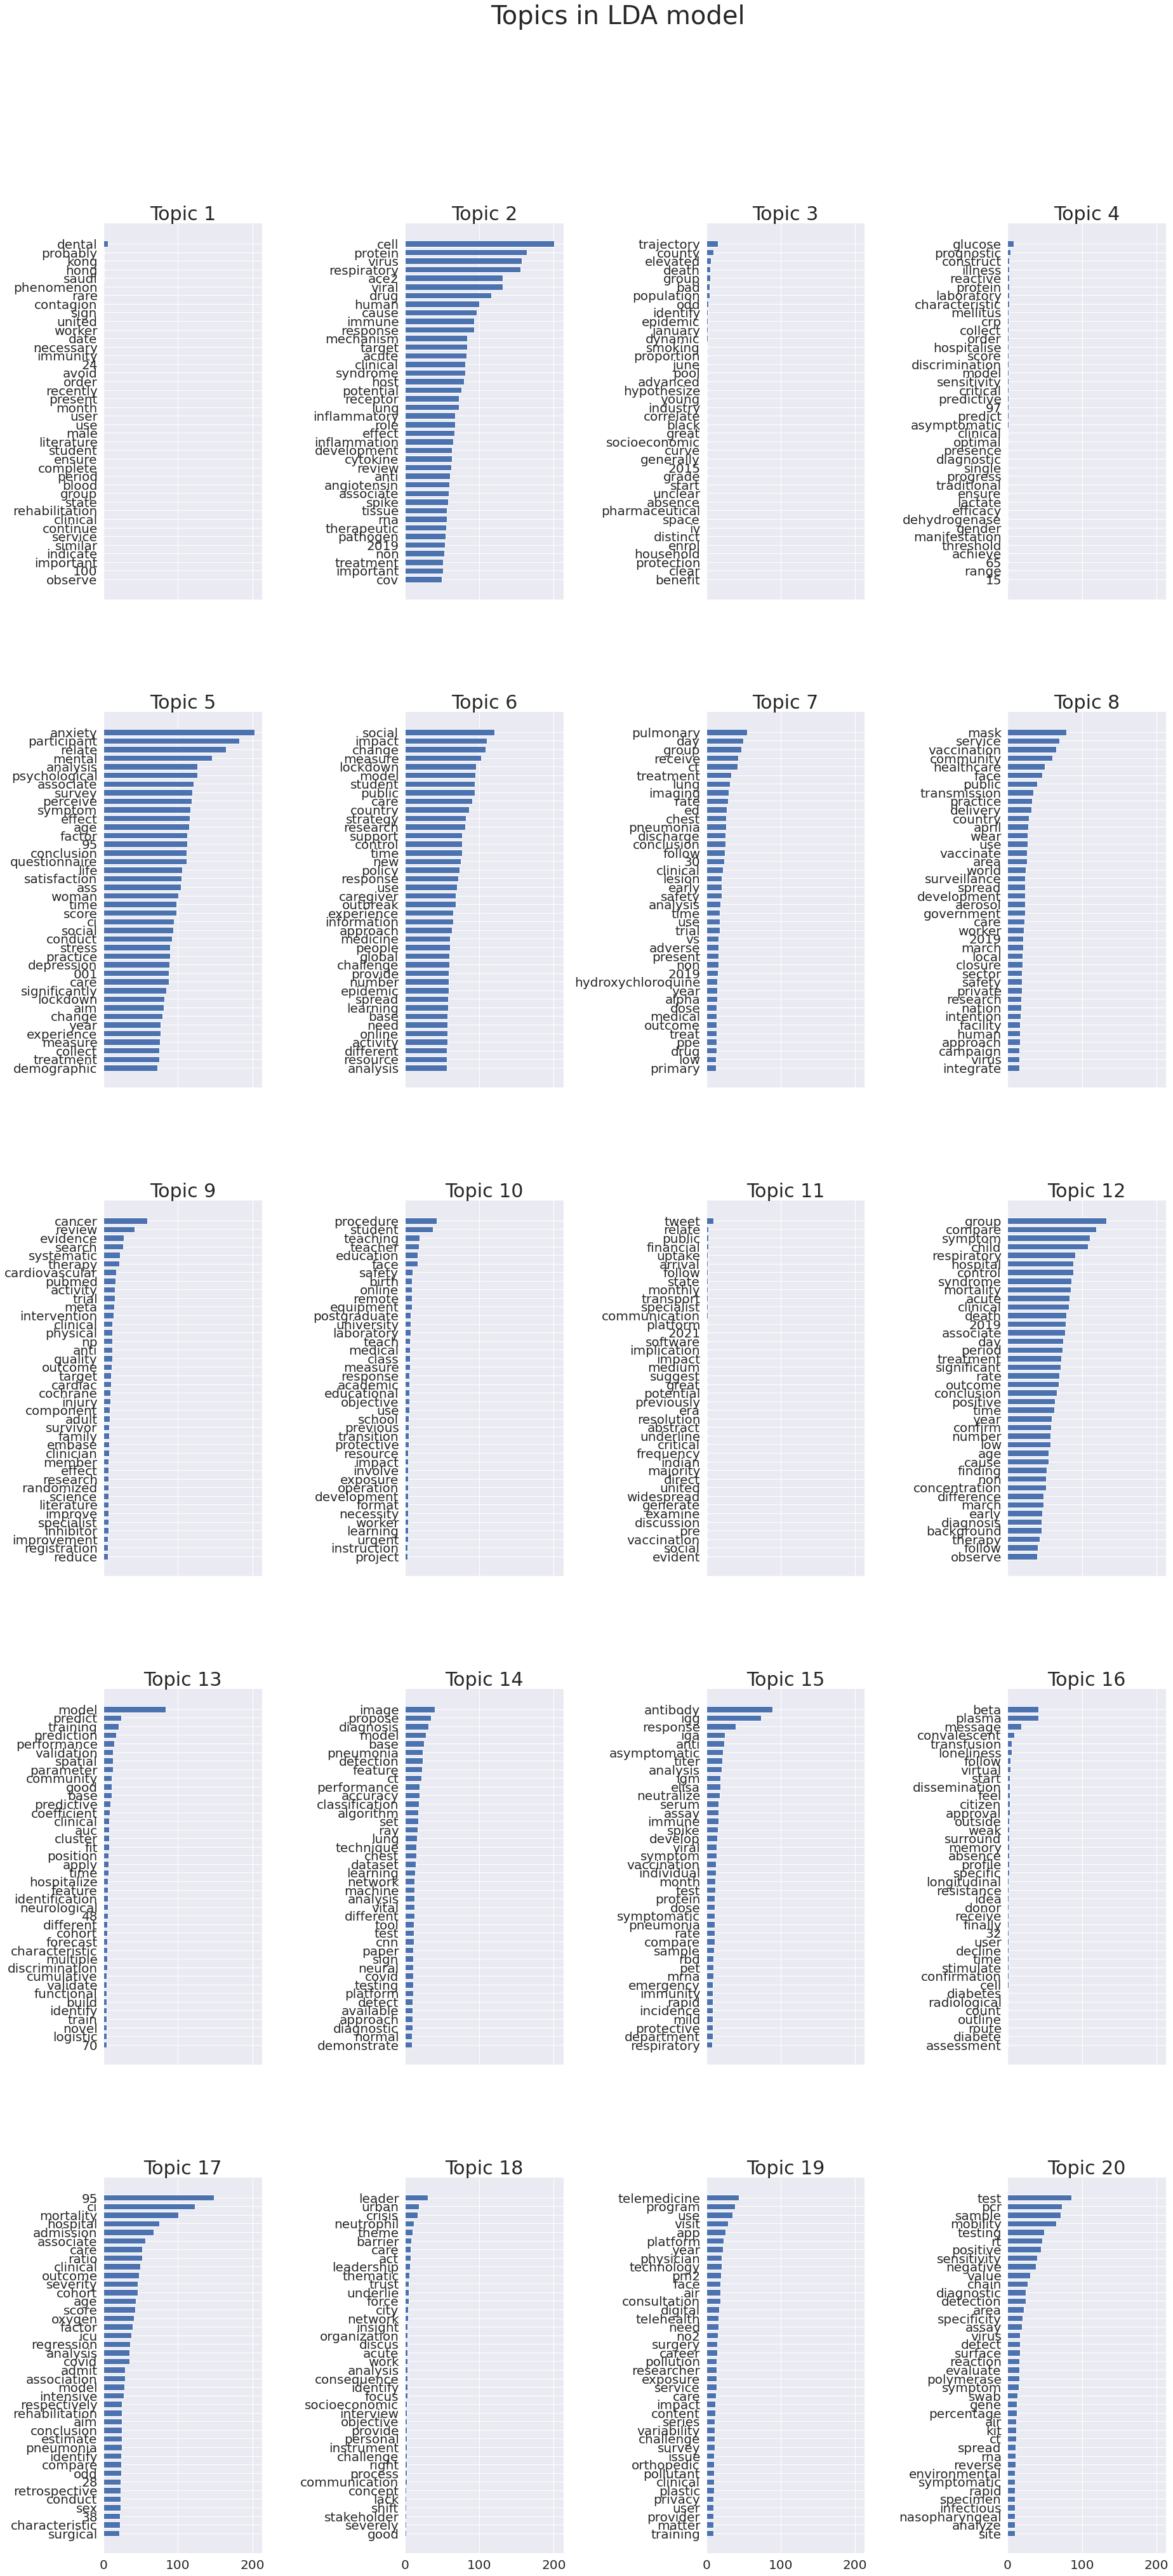

In [104]:
tf_feature_names = tf.get_feature_names()
plot_top_words(lda, tf_feature_names, 40, 'Topics in LDA model')

In [105]:
all_keywords = []
for topic_idx, topic in enumerate(lda.components_):
    #top words = 100
    top_features_ind = topic.argsort()[:-100 - 1:-1]
    top_features = [tfidf_feature_names[i] for i in top_features_ind]
    all_keywords.append(top_features)

In [106]:
for num_clus in range(0,20):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ','.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    TERM_LIST = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,TERM_LIST)
    print("")

*************Cluster  0 *********************
chart,hospitalisation,enhancement,diminish,intensivist,halt,immunisation,blood,irritant,metabolism,monocyte,cc,force,distinct,15,also,genomic,impaired,hipaa,fill,mhv,mg,expect,ethnic,likelihood,conserve,basic,growth,antithrombotic,determinant,law,indecision,august,bot,inventory,isolated,downstream,dl,05,fund,definition,immunothrombosis,low,current,modification,grant,majority,male,differently,face,maglumi,attend,gaming,drug,insulin,droplet,circulate,hr,mapping,friend,german,corona,mother,beta1,by,manifest,measurement,alarming,ieis,forward,homeless,motor,importance,heavy,ace2,hazard,ecological,benchmark,clinician,border,covid,expenditure,alteration,content,asymptomatic,mitigation,dimer,ccp,explain,10,competition,glycosidase,diarrhea,dasc,amid,direct,93,hot,launch,function
-------------------------------------------
TERM_LIST :  ['impaired,hipaa', 'diarrhea']

*************Cluster  1 *********************
arthroplasty,ibd,mitigate,initial,84,m

# LSA

In [107]:
nlp = spacy.load("en_ner_bc5cdr_md")

In [108]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

20

In [109]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0] ," ",end='')
    print(" ")

Topic 0: 
care  group  model  clinical  respiratory  mortality  associate   
Topic 1: 
cell  protein  immune  viral  virus  respiratory  ace2   
Topic 2: 
95  ci  mortality  or  admission  day  icu   
Topic 3: 
anxiety  cell  depression  mental  child  psychological  protein   
Topic 4: 
cell  career  year  stem  researcher  reader  past   
Topic 5: 
student  learning  image  ct  university  pcr  test   
Topic 6: 
child  syndrome  care  respiratory  clinical  review  acute   
Topic 7: 
child  test  pcr  rt  ct  symptom  testing   
Topic 8: 
antibody  igg  hcw  response  rbd  vaccination  care   
Topic 9: 
student  lockdown  child  period  group  pollutant  air   
Topic 10: 
child  95  ci  vaccination  or  manifestation  student   
Topic 11: 
vaccination  group  antibody  vaccinate  hesitancy  drug  plasma   
Topic 12: 
mask  face  wear  respiratory  virus  transmission  95   
Topic 13: 
child  drug  compound  molecular  protease  docking  protein   
Topic 14: 
mask  image  ct  face  we

In [110]:
all_keywords = []
for topic_idx, topic in enumerate(svd_model.components_):
    #top words = 100
    top_features_ind = topic.argsort()[:-40 - 1:-1]
    top_features = [tfidf_feature_names[i] for i in top_features_ind]
    all_keywords.append(top_features)


In [111]:
for num_clus in range(0,19):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ','.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    TERM_LIST = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,TERM_LIST )
    print("")

*************Cluster  0 *********************
care,group,model,clinical,respiratory,mortality,associate,symptom,virus,hospital,cell,response,95,analysis,use,time,anxiety,year,2019,social,treatment,control,factor,base,relate,test,lockdown,age,ci,measure,protein,child,acute,mental,research,syndrome,impact,need,viral,rate
-------------------------------------------
TERM_LIST :  ['anxiety']

*************Cluster  1 *********************
cell,protein,immune,viral,virus,respiratory,ace2,drug,antibody,spike,host,human,response,rna,target,syndrome,rbd,receptor,acute,cov,mechanism,bind,cause,anti,plasma,cytokine,tissue,molecular,protease,enzyme,development,neutralize,epithelial,therapeutic,induce,lung,expression,inflammatory,genome,mouse
-------------------------------------------
TERM_LIST :  []

*************Cluster  2 *********************
95,ci,mortality,or,admission,day,icu,hospital,associate,pneumonia,ct,admit,age,clinical,outcome,test,severity,30,score,symptom,pulmonary,cohort,rate,labor

# Topic Modeling on Each Cluster

Now we will attempt to find the most significant words in each clusters. K-means clustered the articles but did not label the topics. Through topic modeling we will find out what the most important terms for each cluster are. This will add more meaning to the cluster by giving keywords to quickly identify the themes of the cluster.

For topic modeling, we will use LDA (Latent Dirichlet Allocation). In LDA, each document can be described by a distribution of topics and each topic can be described by a distribution of words[.](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158)

In [112]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

First we will create 20 vectorizers, one for each of our cluster labels

In [113]:
vectorizers = []
    
for ii in range(0, 5):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

Now we will vectorize the data from each of our clusters

In [114]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'text_lemmatized_url_html']))
        #d'ou vient df['y'] =   y_pred = kmeans.fit_predict(X_reduced)      df['y'] = y_pred       df['y']
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [115]:
len(vectorized_data)

5

Topic modeling will be performed through the use of Latent Dirichlet Allocation (LDA). This is a generative statistical model that allows sets of words to be explained by a shared topic

# Topic modeling on each cluster using LDA : 

In [116]:
nlp = spacy.load("en_ner_bc5cdr_md")

In [117]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 6

lda_models = []
for ii in range(0, 5):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    

For each cluster, we had created a correspoding LDA model in the previous step. We will now fit_transform all the LDA models on their respective cluster vectors

In [118]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Extracts the keywords from each cluster

In [119]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=20):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

Append list of keywords for a single cluster to 2D list of length NUM_TOPICS_PER_CLUSTER

In [120]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [121]:
for i in range(0,5):
    print(all_keywords[i])

['protein', 'response', 'cov', 'immune', 'cell', 'ace', 'viral', 'host', 'bind', 'lung', 'tissue', 'antibody', 'spike', 'potential', 'rna', 'specific', 'receptor', 'mechanism', 'protease', 'interferon', 'human', 'rbd', 'site', 'individual', 'target', 'base', 'variant', 'non', 'main', 'signal', 'mrna', 'docking', 'associate', 'virus', 'development', 'detect', 'molecular', 'domain', 'neutralize', 'sequence', 'orf', 'interaction', 'syndrome', 'induce', 'compound', 'mutation', 'epitope', 'coronaviruse', 'analysis', 'respiratory', 'mouse', 'inhibitor', 'replication', 'entry', 'demonstrate', 'acute', 'drug', 'pro', 'functional', 'expression', 'identify', 'effective', 'genome', 'structure', 'reveal', 'potent', 'like', 'spread', 'property', 'complex', 'structural', 'indicate', 'transmission', 'novel', 'rate', 'new', 'relationship', 'mortality', 'encode', 'promise']
['anxiety', 'student', 'psychological', 'depression', 'mask', 'public', 'lockdown', 'stress', 'digital', 'satisfaction', 'question

In [122]:
for num_clus in range(0,5):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ','.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    TERM_LIST = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,TERM_LIST )
    print("")

*************Cluster  0 *********************
protein,response,cov,immune,cell,ace,viral,host,bind,lung,tissue,antibody,spike,potential,rna,specific,receptor,mechanism,protease,interferon,human,rbd,site,individual,target,base,variant,non,main,signal,mrna,docking,associate,virus,development,detect,molecular,domain,neutralize,sequence,orf,interaction,syndrome,induce,compound,mutation,epitope,coronaviruse,analysis,respiratory,mouse,inhibitor,replication,entry,demonstrate,acute,drug,pro,functional,expression,identify,effective,genome,structure,reveal,potent,like,spread,property,complex,structural,indicate,transmission,novel,rate,new,relationship,mortality,encode,promise
-------------------------------------------
TERM_LIST :  []

*************Cluster  1 *********************
anxiety,student,psychological,depression,mask,public,lockdown,stress,digital,satisfaction,questionnaire,relate,treatment,work,conclusion,practice,score,participant,quality,change,mental,behavior,country,vaccination,mod

# Topic modeling on each cluster using NMF : 

In [123]:
nlp = spacy.load("en_ner_bc5cdr_md")

In [124]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 6

nmf_models = []
for ii in range(0, 5):
    # nmf
    nmf = NMF(n_components=NUM_TOPICS_PER_CLUSTER, random_state=1,alpha=.1, l1_ratio=.5)
    nmf_models.append(nmf)
    
nmf_models[0]

NMF(alpha=0.1, beta_loss='frobenius', init=None, l1_ratio=0.5, max_iter=200,
    n_components=6, random_state=1, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [125]:
clusters_nmf_data = []

for current_cluster, nmf in enumerate(nmf_models):
    print("Current Cluster: " + str(current_cluster))
    if vectorized_data[current_cluster] != None:
        clusters_nmf_data.append((nmf.fit_transform(vectorized_data[current_cluster])))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4


In [126]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=20):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [127]:
all_keywords = []
for current_vectorizer, nmf in enumerate(nmf_models):
    # print("Current Cluster: " + str(current_vectorizer))
    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(nmf, vectorizers[current_vectorizer]))

In [128]:
for i in range(0,5):
    print(all_keywords[i])

['protein', 'cov', 'cell', 'ace', 'host', 'spike', 'viral', 'antibody', 'protease', 'interferon', 'immune', 'main', 'rbd', 'induce', 'human', 'response', 'bind', 'target', 'orf', 'compound', 'docking', 'virus', 'respiratory', 'receptor', 'pathway', 'rna', 'neutralize', 'pro', 'lung', 'epitope', 'variant', 'epithelial', 'site', 'expression', 'investigate', 'effect', 'non', 'tissue', 'syndrome', 'acute', 'inhibitor', 'understand', 'mouse', 'simulation', 'evaluate', 'multiple', 'model', 'surface', 'interaction', 'specific', 'dynamic', 'present', 'base', 'identify', 'effective', 'structural', 'affect', 'role', 'development', 'vitro', 'functional', 'conformation', 'acid', 'long', 'type', 'cause', 'interact', 'mechanism', 'pathogenesis', 'gene', 'repurpose', 'objective', 'need', 'angiotensin', 'develop', 'potential', 'signal', 'pattern', 'observe', 'entry', 'use', 'form', 'total', 'drug', 'molecular', 'replication', 'analysis', 'active', 'novel', 'associate', 'highly']
['mental', 'mask', 'an

## travail realisé :
 - detection automatique des noms de maladies
 - construction d'un corpus en utilisant les noms des maladies detectés

In [129]:
for num_clus in range(0,5):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ','.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    TERM_LIST = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,TERM_LIST )
    print("")


*************Cluster  0 *********************
protein,cov,cell,ace,host,spike,viral,antibody,protease,interferon,immune,main,rbd,induce,human,response,bind,target,orf,compound,docking,virus,respiratory,receptor,pathway,rna,neutralize,pro,lung,epitope,variant,epithelial,site,expression,investigate,effect,non,tissue,syndrome,acute,inhibitor,understand,mouse,simulation,evaluate,multiple,model,surface,interaction,specific,dynamic,present,base,identify,effective,structural,affect,role,development,vitro,functional,conformation,acid,long,type,cause,interact,mechanism,pathogenesis,gene,repurpose,objective,need,angiotensin,develop,potential,signal,pattern,observe,entry,use,form,total,drug,molecular,replication,analysis,active,novel,associate,highly
-------------------------------------------
TERM_LIST :  []

*************Cluster  1 *********************
mental,mask,anxiety,student,social,depression,care,relate,perceive,learning,measure,service,participant,non,stress,community,distancing,lockdow

In [130]:
from Bio import Entrez
from Bio import Medline
import json


MAX_COUNT = 3
for TERM in ten_diseases:
    Entrez.email = 'A.N.Other@example.com'
    h = Entrez.esearch(db='pubmed', retmax=MAX_COUNT, term=TERM)
    result = Entrez.read(h)
    ids = result['IdList']
    h = Entrez.efetch(db='pubmed', id=ids, rettype='medline', retmode='json')
    records = Medline.parse(h)
    i=0
    for record in records:
        filename="fichier_"+TERM+str(i)+".json"
        json.dump(record, open(".\\new_corpus\\"+filename, 'w'))
        data = json.load(open(".\\new_corpus\\"+filename))
        i=i+1
[(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents]

[]

In [131]:
len(all_keywords)

5